<a href="https://colab.research.google.com/github/GeneSUN/Anomaly_Detection_toolkit/blob/main/Kernel_Density_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novelty Detection Project
This notebook contains three section

## 1. Outlier Detection on a Single Time Series
- **Goal:** Identify anomalous points across A single univariate time series, ordered by time.  

---

## 2. Novelty Detection on a Single Time Series (Final Point Only)
- **Goal:** Shift focus from *global* anomalies to *novelty at the most recent observation*.  
- **Setup:** Same single series, but only the **final point** is under evaluation.  
- **Process:**  
  - Train the model on the historical portion of the series.  
  - Score only the final observation against the learned distribution.  
  - Decide whether this last point is novel/unexpected relative to prior behavior.  
- **Purpose:** Mimic real-time monitoring use cases where only the *latest value* matters.

---

## 3. Sliding-Window Novelty Detection on Consecutive Series
- **Goal:** Extend Section 2 into a rolling detection framework.  
- **Setup:**  
  - Construct multiple overlapping series windows:  
    - Example: `[1,2,3,4,5,6,7]`, `[2,3,4,5,6,7,8]`, …  
  - Each window is treated as a separate “mini-series.”  
- **Purpose:** Produce a dynamic anomaly timeline that captures how novelty evolves as the series progresses.

---


In [3]:
!wget https://raw.githubusercontent.com/GeneSUN/Anomaly_Detection_toolkit/main/KDE/FeaturewiseKDENoveltyDetector.py

# Now you can import it
from FeaturewiseKDENoveltyDetector import FeaturewiseKDENoveltyDetector


--2025-09-18 00:29:45--  https://raw.githubusercontent.com/GeneSUN/Anomaly_Detection_toolkit/main/KDE/FeaturewiseKDENoveltyDetector.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11734 (11K) [text/plain]
Saving to: ‘FeaturewiseKDENoveltyDetector.py.1’

FeaturewiseKDENovel 100%[===================>]  11.46K  --.-KB/s    in 0s      

2025-09-18 00:29:45 (35.3 MB/s) - ‘FeaturewiseKDENoveltyDetector.py.1’ saved [11734/11734]



In [4]:
import pandas as pd

# GitHub repo URL (make sure to use the raw file)
url = "https://raw.githubusercontent.com/GeneSUN/Anomaly_Detection_toolkit/main/Data/Single_Series.csv"

df = pd.read_csv(url)
df['customer'] = df['customer'].astype(str)
df['time'] = pd.to_datetime(df['time'])
display(df.info())


print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   customer  2000 non-null   object        
 1   time      2000 non-null   datetime64[ns]
 2   Feature   2000 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.0+ KB


None

   customer                time  Feature
0  24704908 2025-06-30 21:52:31      6.0
1  24704908 2025-06-30 22:22:38      7.0
2  24704908 2025-06-30 22:52:42      5.0
3  24704908 2025-06-30 23:52:27      7.0
4  24704908 2025-07-01 00:22:29      7.0


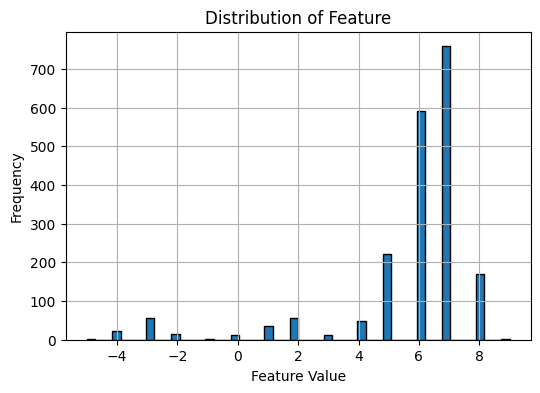

In [ ]:
#@title Distribution of Feature
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(df['Feature'], bins=50, edgecolor='black')
plt.title('Distribution of Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 1.Outlier Detection on a Single Time Series

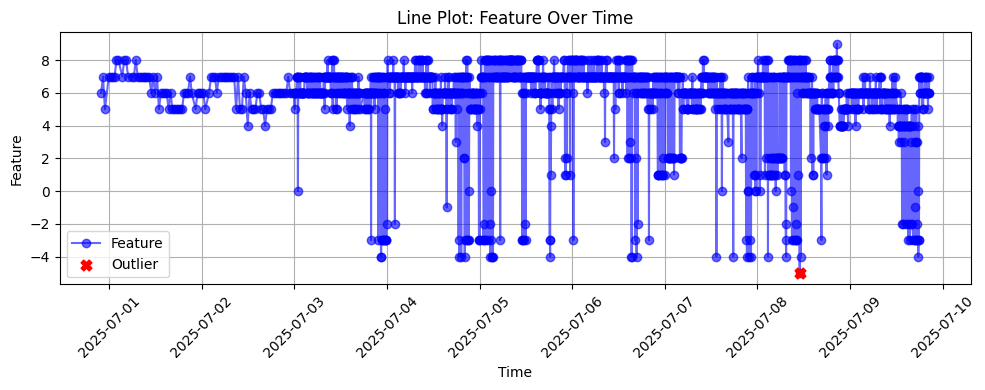

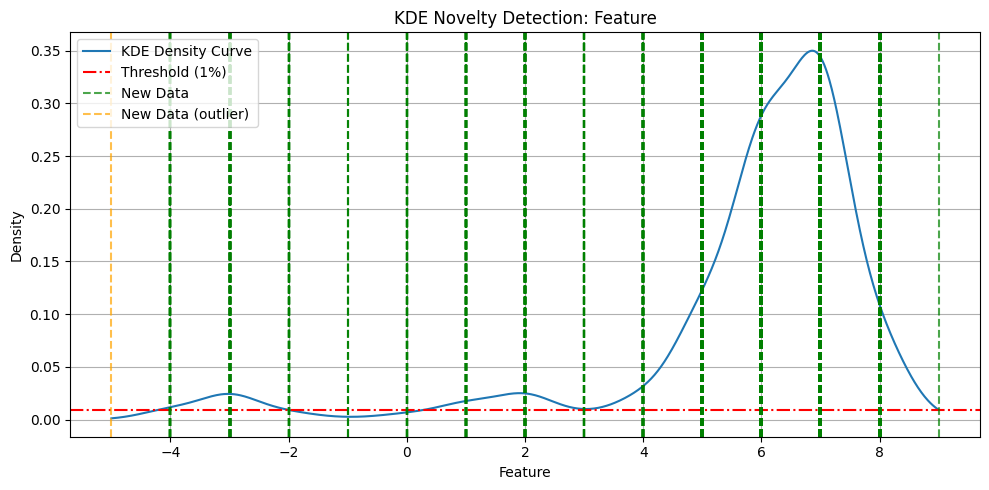

In [5]:

single_kde_detector =   FeaturewiseKDENoveltyDetector(df = df,
                                                      customer_id = "customer",
                                                      feature_col = "Feature",
                                                      time_col = "time",
                                                      bandwidth = 0.5,
                                                      train_idx = "all",
                                                      new_idx = "all",  # when new_idx is set as all, this become outlier detection
                                                      filter_percentile = 99,
                                                      threshold_percentile = 99,
                                                      anomaly_direction="low"
                                                      )
single_kde_detector.fit()

single_kde_detector.plot_line()

single_kde_detector.plot_kde()

# 2.Novelty Detection on a Single Time Series (Final Point Only)

Change parameter **`new_idx = "all"`** to **`new_idx =slice(-1, None),`**

You can also use **`new_idx =slice(-n, None)`** to detect the last **`n`** points

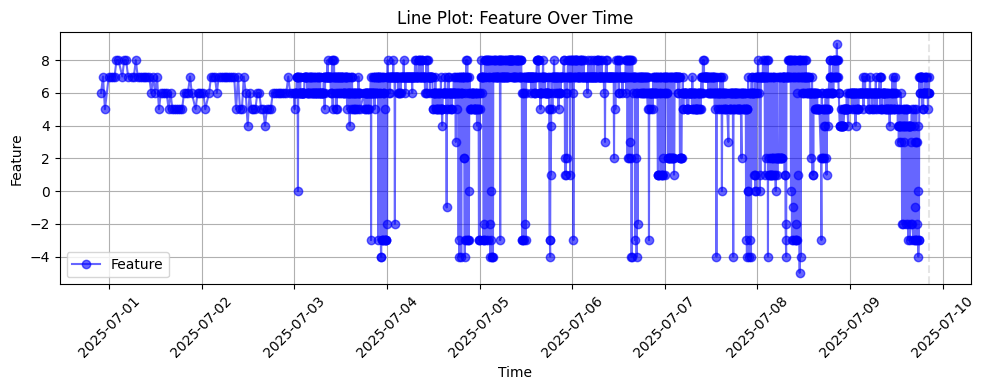

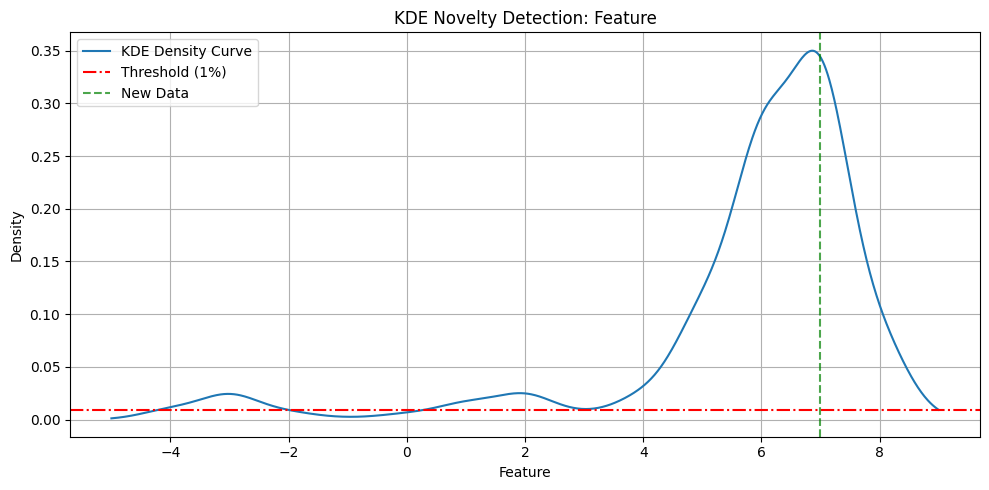

In [6]:

single_kde_detector =   FeaturewiseKDENoveltyDetector(df = df,
                                                      customer_id = "customer",
                                                      feature_col = "Feature",
                                                      time_col = "time",
                                                      filter_percentile = 99,
                                                      new_idx =slice(-1, None),  # when new_idx is set as slice(-1, None), this become Novelty detection, -1 indicates the most recent one
                                                      threshold_percentile = 99,
                                                      anomaly_direction="low"
                                                      )
single_kde_detector.fit()

single_kde_detector.plot_line()

single_kde_detector.plot_kde()

# 3.Sliding-Window Novelty Detection on Consecutive Series

This DataFrame contains data structured into multiple overlapping time series windows.

*   **Sliding Windows:** The data is organized into consecutive, overlapping segments of the original time series. Each segment represents a "window" of data points. For example, if the original series is [1, 2, 3, 4, 5, 6, 7, 8], the windows might be [1, 2, 3, 4, 5, 6, 7] and [2, 3, 4, 5, 6, 7, 8].
*   **`slice_id`:** Each unique `slice_id` identifies a specific sliding window. All data points within a particular window share the same `slice_id`. This ID typically corresponds to the starting point (or time) of that window in the original time series.

eg. The slice id 1751329444 corresponds to: 2025-07-01 00:24:04

In [14]:
import pandas as pd

# GitHub repo URL (make sure to use the raw file)
url = "https://raw.githubusercontent.com/GeneSUN/Anomaly_Detection_toolkit/main/Data/novelty_window.csv"


df = pd.read_csv(url)

df.rename(columns={"5GSNR": "Feature", "sn": "customer"}, inplace=True)
df['customer'] = df['customer'].str[2:]

df['customer'] = df['customer'].astype(str)
df['slice_id'] = df['slice_id'].astype(str)
df['time'] = pd.to_datetime(df['time'])

display(df.info())


print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541000 entries, 0 to 1540999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype                    
---  ------    --------------    -----                    
 0   customer  1541000 non-null  object                   
 1   time      1541000 non-null  datetime64[ns, UTC-04:00]
 2   Feature   1541000 non-null  float64                  
 3   slice_id  1541000 non-null  object                   
dtypes: datetime64[ns, UTC-04:00](1), float64(1), object(2)
memory usage: 47.0+ MB


None

    customer                      time  Feature    slice_id
0  B24704908 2025-06-30 20:24:04-04:00      5.0  1751329444
1  B24704908 2025-06-30 20:52:50-04:00      4.0  1751329444
2  B24704908 2025-06-30 21:22:39-04:00      5.0  1751329444
3  B24704908 2025-06-30 21:52:31-04:00      6.0  1751329444
4  B24704908 2025-06-30 22:22:38-04:00      7.0  1751329444


In [15]:
#@title Python Parallel process
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from functools import partial

# --- Your detector function (slightly modified) ---
def detect_kde_novelty(group_df: pd.DataFrame, feature_col: str, time_col: str) -> pd.DataFrame:
    group_df = group_df.sort_values(time_col)

    detector = FeaturewiseKDENoveltyDetector(
        df=group_df,
        feature_col=feature_col,
        time_col=time_col,
        filter_percentile=100,
        threshold_percentile=99,
        anomaly_direction="low",
        train_idx="all",
        new_idx=slice(-1, None),
    )
    return detector.fit()

# --- Group and parallel apply ---
def parallel_group_apply(df: pd.DataFrame, group_col: str, func, workers: int = 4, **kwargs):
    results = []
    with ProcessPoolExecutor(max_workers=workers) as executor:
        futures = []
        for _, g in df.groupby(group_col):
            futures.append(executor.submit(func, g, **kwargs))
        for f in futures:
            results.append(f.result())
    return pd.concat(results, ignore_index=True)

# --- Usage ---
df_anomaly_result = parallel_group_apply(
    df,
    group_col="slice_id",
    func=detect_kde_novelty,
    workers=8,  # adjust based on CPU
    feature_col="Feature",
    time_col="time"
)


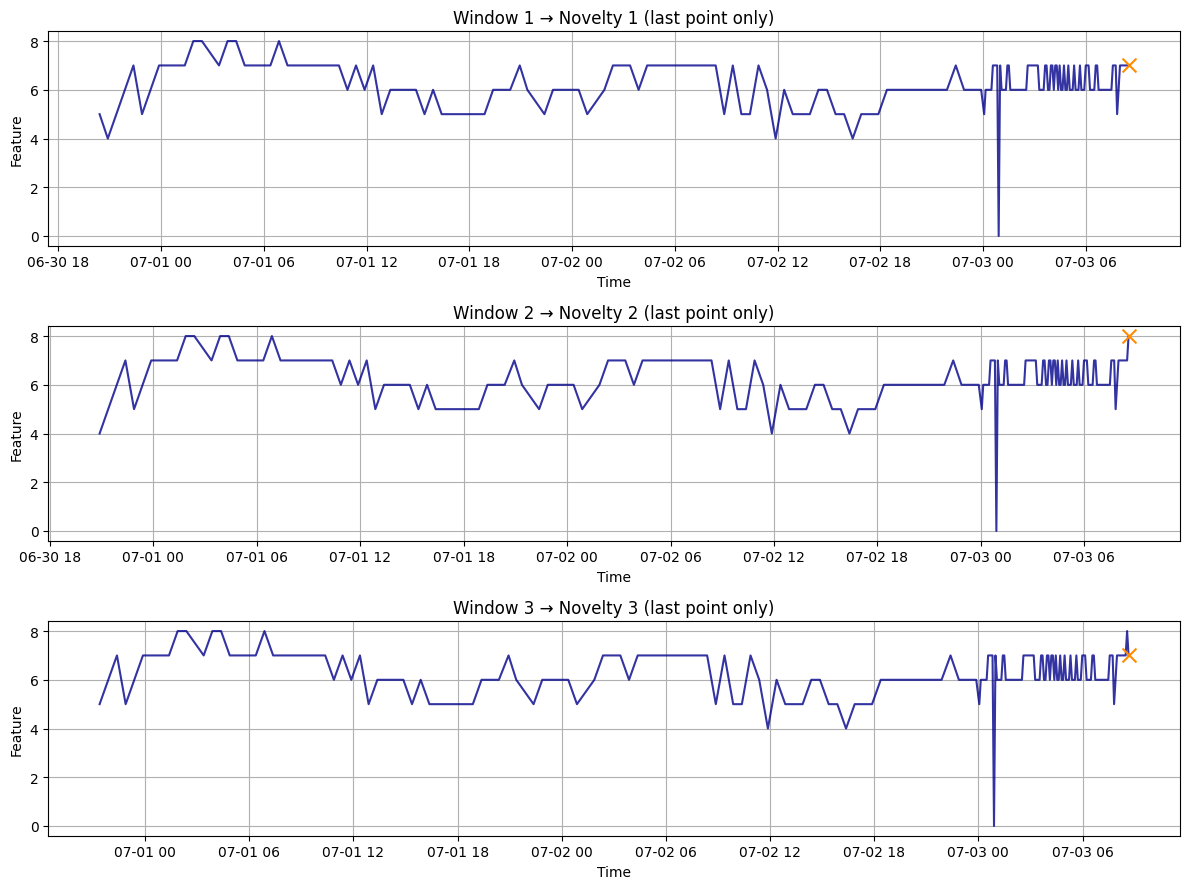

In [35]:
#@title ## Plot of Each Single Series (Last-Point Novelty)
import matplotlib.pyplot as plt

df_line = df[['customer', 'time', 'Feature']].drop_duplicates().reset_index(drop=True)
window_size = 200
N = 3  # how many windows to show

fig, axes = plt.subplots(N, 1, figsize=(12, 3*N), sharey=True)

for i in range(N):
    start_idx = i
    end_idx = i + window_size
    segment = df_line.iloc[start_idx:end_idx]

    # Plot the window as a line
    axes[i].plot(segment['time'], segment['Feature'],
                 color='darkblue', linewidth=1.5, alpha=0.8)

    # Mark only the last point (novelty check)
    last_point = segment.iloc[-1]
    axes[i].scatter(last_point['time'], last_point['Feature'],
                    color='darkorange', marker='x', s=100, zorder=5)

    # Add title showing it's novelty detection on last point
    axes[i].set_title(f"Window {i+1} → Novelty {i+1} (last point only)")

    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Feature")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [38]:
#@title Summary of All Consecutive Series Novelties (Interactive)
import plotly.express as px

# Make sure DataFrames are ready
df_line = df[['customer', 'time', 'Feature']].drop_duplicates()
df_scatter = df_anomaly_result

# Line chart
fig = px.line(df_line, x="time", y="Feature", title="Summary of All Consecutive Series Novelties")

# Add novelty points as scatter
fig.add_scatter(x=df_scatter["time"], y=df_scatter["Feature"],
                mode="markers",
                marker=dict(color="darkorange", symbol="x", size=10),
                name="Novelty Points")

# Show interactive plot
fig.show()


# Appendix

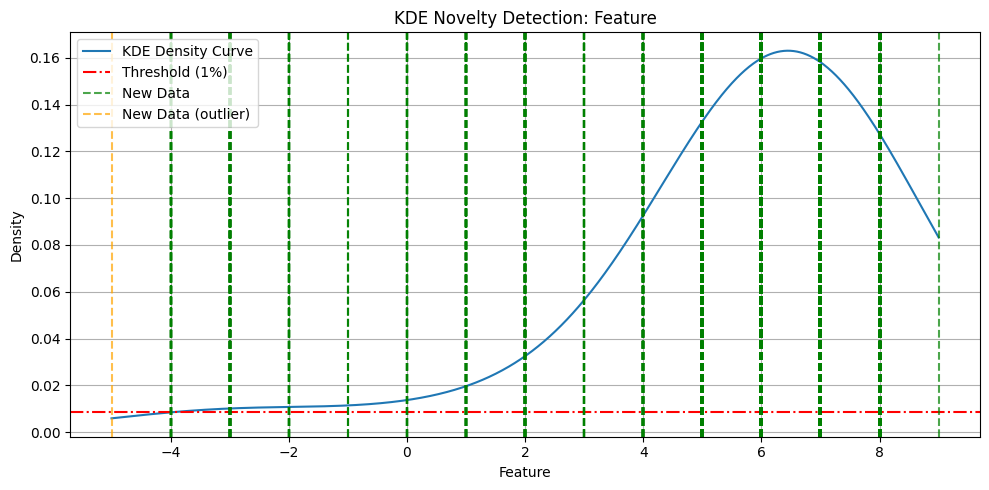

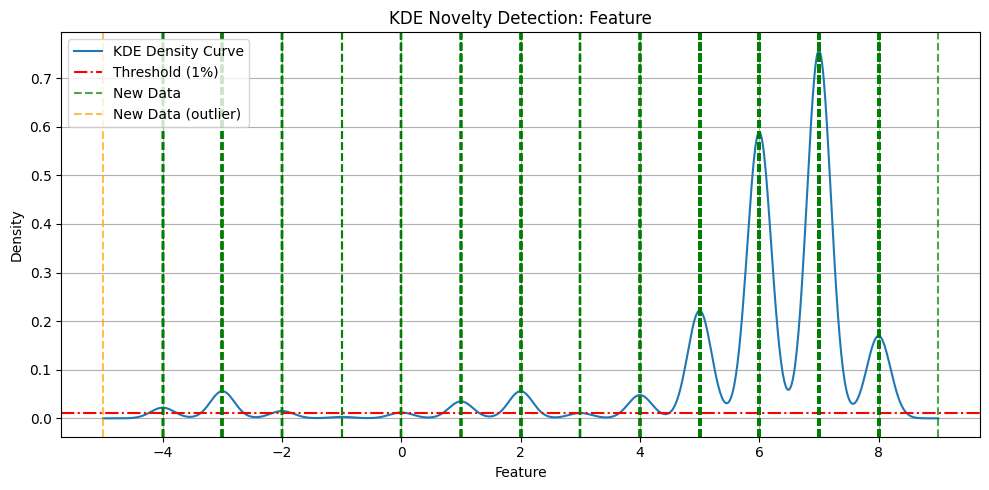

In [7]:
#@title Hyperparameter Tuning-bandwidth
#@markdown A larger value of bandwidth creates a smoother estimated distribution.
single_kde_detector =   FeaturewiseKDENoveltyDetector(df = df,
                                                      customer_id = "customer",
                                                      feature_col = "Feature",
                                                      time_col = "time",
                                                      bandwidth = 2,
                                                      train_idx = "all",
                                                      new_idx = "all",  # when new_idx is set as all, this become outlier detection
                                                      filter_percentile = 99,
                                                      threshold_percentile = 99,
                                                      anomaly_direction="low"
                                                      )
single_kde_detector.fit()
single_kde_detector.plot_kde()

single_kde_detector =   FeaturewiseKDENoveltyDetector(df = df,
                                                      customer_id = "customer",
                                                      feature_col = "Feature",
                                                      time_col = "time",
                                                      bandwidth = 0.2,
                                                      train_idx = "all",
                                                      new_idx = "all",  # when new_idx is set as all, this become outlier detection
                                                      filter_percentile = 99,
                                                      threshold_percentile = 99,
                                                      anomaly_direction="low"
                                                      )
single_kde_detector.fit()
single_kde_detector.plot_kde()

## Distributed Computation with Spark applyInPandas

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import sum, lag, col, split, concat_ws, lit ,udf,count, max,lit,avg, when,concat_ws,to_date,explode,last
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, FloatType, BooleanType

TIME_COL = "Time"
FEATURE_COL = "Feature"

# 2. Define output schema
schema = StructType([
                    StructField("customer", StringType(), True),
                    StructField(TIME_COL, TimestampType(), True),
                    StructField(FEATURE_COL, FloatType(), True),
                    StructField("is_outlier", BooleanType(), True)
                ])

# 3. UDF
def detect_kde_outliers(group_df: pd.DataFrame) -> pd.DataFrame:
    if len(group_df) < 10:
        return pd.DataFrame([], columns=schema.fieldNames())
    try:
        group_df = group_df.sort_values(TIME_COL)
        detector = FeaturewiseKDENoveltyDetector(
                                                    df=group_df,
                                                    feature_col=FEATURE_COL,
                                                    time_col=TIME_COL,
                                                    train_idx="all",
                                                    new_idx="all",
                                                    filter_percentile=100,
                                                    threshold_percentile=95,
                                                    anomaly_direction="low"
                                                )
        return detector.fit()
    except Exception:
        return pd.DataFrame([], columns=schema.fieldNames())

# 4. Run anomaly detection in parallel
df_anomaly_result = df.groupBy("customer").applyInPandas(detect_kde_outliers, schema=schema)
